In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import load_data as ld
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras import datasets, layers, models

print(tf.__version__)

2.6.0


In [31]:
ip_data = np.load("../data/1988_lanina_ip_sp.npy")[[7]]

In [32]:
model = keras.models.load_model("../data/model/exp1_pretrain_op1_sp")

In [33]:
model.predict(ip_data)

array([[-1.4238476]], dtype=float32)

In [34]:
model.layers[-1].get_weights()[0]

array([[-0.16844611],
       [ 0.09017116],
       [-0.11765617],
       [ 0.06599605],
       [-0.01189968],
       [-0.19227766],
       [ 0.15707292],
       [ 0.00723128],
       [-0.06566024],
       [ 0.10969543],
       [ 0.08203817],
       [-0.17395264],
       [ 0.12070144],
       [ 0.11735234],
       [ 0.03886016],
       [-0.17216425],
       [-0.14212278],
       [-0.14808159],
       [-0.085887  ],
       [ 0.25090572],
       [ 0.13374236],
       [-0.13756372],
       [ 0.00140533],
       [-0.23661229],
       [-0.05003256],
       [-0.09564912],
       [-0.21188506],
       [ 0.08842809],
       [ 0.11627685],
       [ 0.13928159]], dtype=float32)

In [35]:
last_conv_layer_name = "conv2d_5"
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
)
grad_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  [(None, 24, 72, 6)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 72, 30)        5790      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 36, 30)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 36, 30)        28830     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 18, 30)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 18, 30)         28830     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3240)              0   

In [36]:
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(ip_data)
    class_channel = preds[:,0]
grads = tape.gradient(class_channel, last_conv_layer_output)
grads.shape,preds.shape

(TensorShape([1, 6, 18, 30]), TensorShape([1, 1]))

In [37]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
# pooled_grads = grads
grads.shape,pooled_grads.shape

(TensorShape([1, 6, 18, 30]), TensorShape([30]))

In [38]:
last_conv_layer_output = last_conv_layer_output[0]

In [39]:
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]

In [40]:
heatmap.shape

TensorShape([6, 18, 1])

In [41]:
heatmap = tf.squeeze(heatmap)
heatmap

<tf.Tensor: shape=(6, 18), dtype=float32, numpy=
array([[ 0.0402028 ,  0.0428624 ,  0.03956685,  0.03087769,  0.02136577,
         0.02103443,  0.01408043,  0.00288152,  0.00131249, -0.00190372,
         0.00180271,  0.00350373,  0.00330975,  0.00356533,  0.00887081,
         0.0077482 ,  0.00271104, -0.00425221],
       [ 0.03384231,  0.03226887,  0.02751453,  0.01454543,  0.02062163,
         0.02427876,  0.01399628, -0.00069607, -0.00848651, -0.0033324 ,
        -0.00736852,  0.00644792,  0.00939355,  0.00950669,  0.01069513,
         0.01284584,  0.01260513,  0.01360328],
       [ 0.03105646,  0.02800278,  0.02456588,  0.01889666,  0.01077444,
         0.01360596,  0.01079222,  0.01859947,  0.02178271,  0.02130081,
         0.02803567,  0.0205726 ,  0.02224146,  0.02573021,  0.02049711,
         0.01635711,  0.01271959,  0.01151167],
       [ 0.04865666,  0.04386749,  0.03796303,  0.03489869,  0.03101378,
         0.02745976,  0.02825006,  0.03198756,  0.02704631,  0.02483002,
    

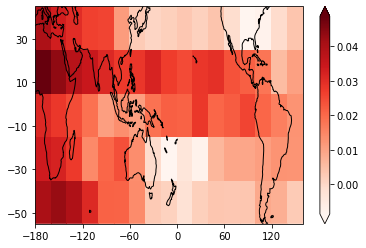

In [46]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

x = np.arange(0,356,5)[::4]
y = np.arange(-55,61,5)[::4]
x1 = np.arange(0, 356, 5)
y1 = np.arange(-55, 61, 5)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
draw_s = np.copy(ip_data[0, :, :, 1])
draw_s[draw_s == 0] = np.NAN

plt.pcolor(x,y,heatmap,cmap="Reds",transform=ccrs.PlateCarree())
# m = ax.contour(x1, y1, draw_s, transform=ccrs.PlateCarree(),levels=np.linspace(-5,5,13),colors='k')
# ax.clabel(m, fmt="%.2f")
plt.colorbar(extend="both")
ax.set_aspect("auto")
xtk = np.arange(-180,180,60)
ax.set_xticks(xtk,crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-50,50,20),crs=ccrs.PlateCarree())
ax.coastlines()

In [51]:
x = np.arange(0,356,5)[::4]
y = np.arange(-55,61,5)[::4]
x.shape,y.shape

((18,), (6,))

In [70]:
# np.save("../data/heatmap_1_res",heatmap)